In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from cam import loadstack 
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
#import torchvision.transforms.functional as F
import torchsummary
import torchvision
%matplotlib notebook
from scipy.ndimage import gaussian_filter

In [2]:
stack_filename = 'prova.zip'
s = loadstack(stack_filename)

<IPython.core.display.Javascript object>


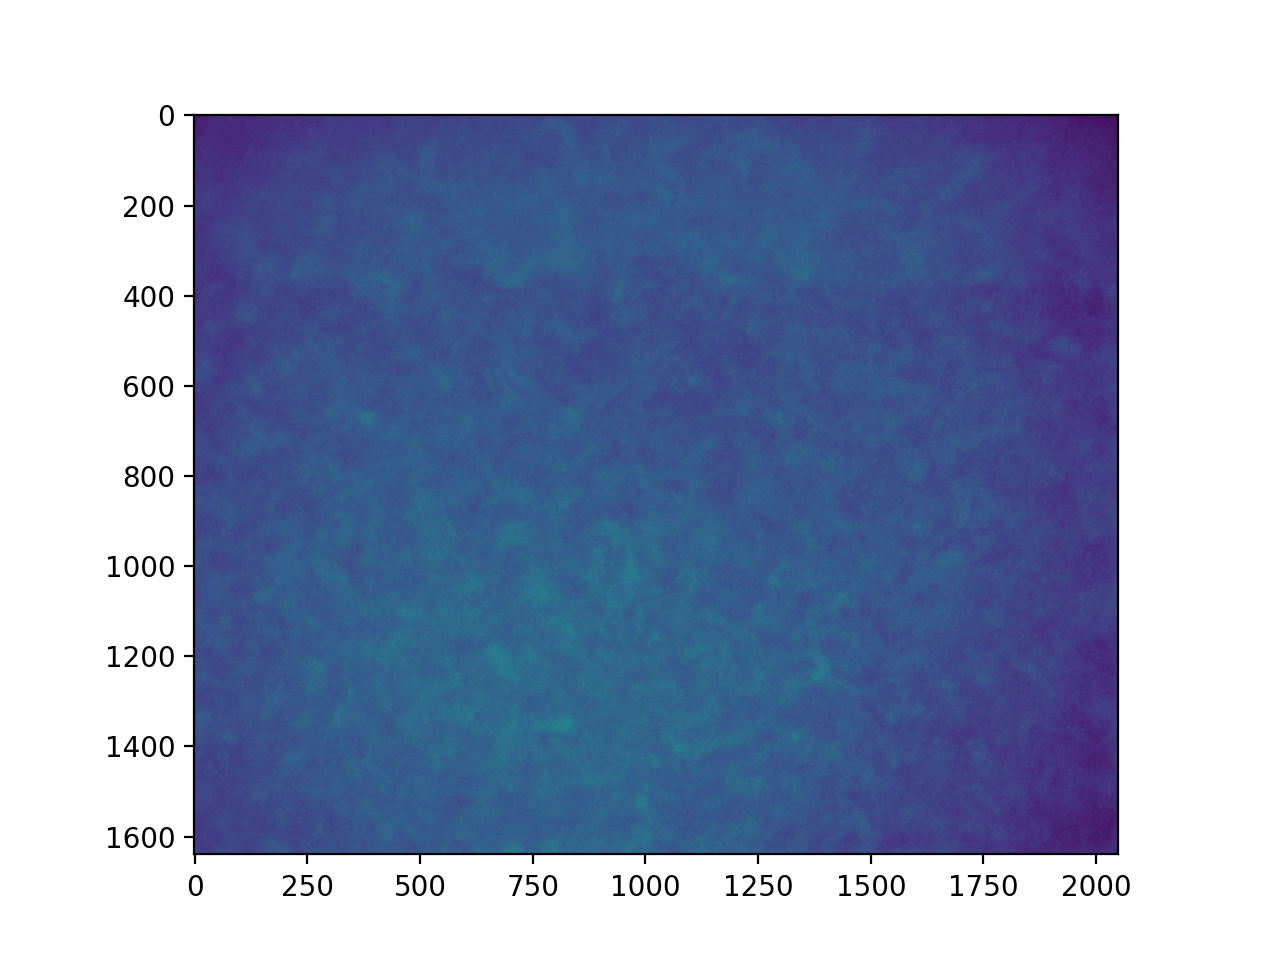

In [3]:
plt.figure()
plt.imshow(s[0].data)

In [5]:
bg = gaussian_filter(s[0].data.astype(float),100)

In [6]:
size = 512
x_min,y_min = [500,500]
sl = tuple([slice(y_min,y_min + size),slice(x_min,x_min + size)])
def preprocess(img):
    img = img.astype(float)/bg
    img = img.astype(float)/(2**16-1)
    img = img[sl]
    img = (img - img.min())/img.ptp()
    return img

<IPython.core.display.Javascript object>


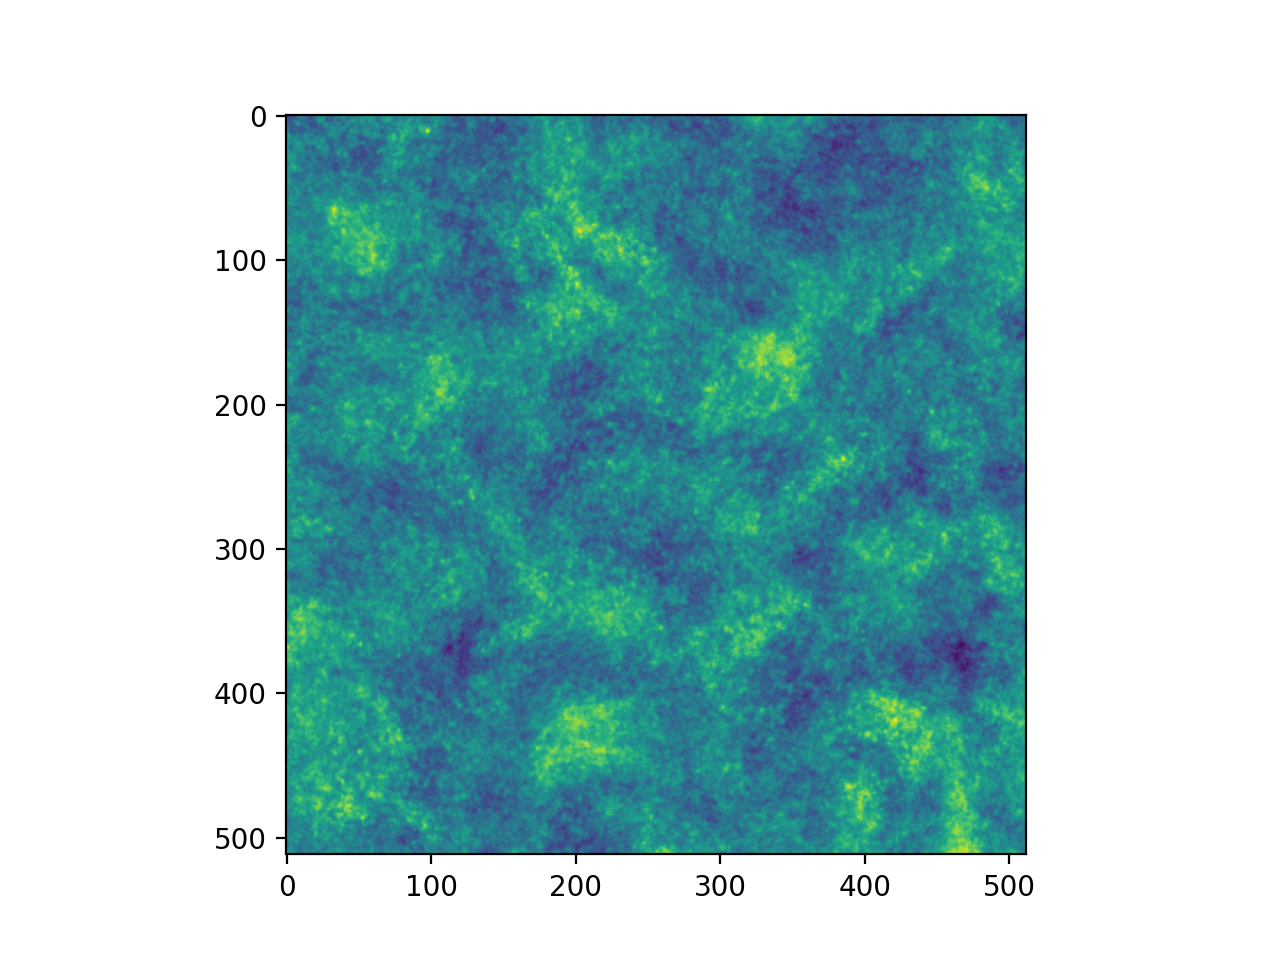

In [7]:
plt.figure()
img = preprocess(s[0].data)
plt.imshow(img)

## loading the training set

In [8]:
class FlowDataset(Dataset):
    def __init__(self,
                 stack,index):
        """
        Dataset for flow image
        Parameters
        ----------
        filename : str
            file path for the stack
        index : array
            numpy array with indices to analyse
        """
        self.stack = loadstack(stack)
        self.index = index
        
    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):

        idx = self.index[idx]
        
        sample_1 = torch.Tensor(preprocess(self.stack[idx].data)).unsqueeze(0)
        sample_2 = torch.Tensor(preprocess(self.stack[idx + 1].data)).unsqueeze(0)

        sample = torch.cat((sample_1,sample_2),dim = 0)
        return sample

In [9]:
from sklearn.model_selection import ShuffleSplit

In [10]:
test_size = 0.1
val_size = 0.2
total_imgs = np.arange(0,len(s),1)

shuffler = ShuffleSplit(n_splits=1, test_size=test_size,random_state=2).split(total_imgs)



indices = [i for i in shuffler]
print(indices[0])
X_train = indices[0][0]
X_test = indices[0][1]
print(X_test.shape,X_train.shape)
shuffler = ShuffleSplit(n_splits=1, test_size=val_size,random_state=2).split(X_train)
X_train,X_vali = next(iter(shuffler))
print(X_train.shape,X_test.shape,X_vali.shape,len(s))

(array([128,  84,  24,  30,  64, 241, 127,  20,  28, 180, 131,  90, 126,
       101, 221, 220,  23, 222, 208,  14,  29, 225,  18, 169, 214, 176,
        25, 115, 120, 181, 242, 140, 160, 229, 234,  66,  44, 130,   6,
        12, 154,   5, 203,   2, 217, 164, 113, 192, 111, 172, 163, 133,
        99, 156,  89, 166,   9, 186, 249,  45, 112, 173, 248, 142,  48,
        42, 147, 197, 209,  57, 230, 152,  79, 114, 207, 243, 231, 153,
       216, 122,   1,  11, 215, 199, 224,   8, 165, 223, 151, 187, 141,
       134, 106, 157,  98, 219, 155,  21, 159, 119, 184, 211, 139,  78,
       191, 238, 108, 179, 201, 171,  82, 135, 205, 188, 239, 233,  36,
        92,  62,   0,  27, 100, 202, 200, 183, 143,  17,  59, 175, 161,
       149, 123,  55,  16, 206, 190, 193,  87, 146,  97, 125,  61,  81,
       252,  68, 129,  56,  19,  86,  70, 137,  60,  34,  40, 138,  76,
       228,  26,  32, 247,  96,  83, 110, 105, 185,  73, 117, 150, 145,
       212, 251, 178, 136, 174,  39,  49, 236, 132,  50, 204,  

In [11]:
train_dataset = FlowDataset(stack_filename,X_train)
vali_dataset  = FlowDataset(stack_filename,X_vali)
test_dataset  = FlowDataset(stack_filename,X_test)

In [1]:
sample = train_dataset[0]
print(sample.size())

NameError: name 'train_dataset' is not defined

In [12]:
batch_size = 4
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
vali_loader = DataLoader(vali_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [12]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def Backward(tensorInput, tensorFlow):
    """
    Evaluate the image with a backpropagation from the flow

    Parameters
    ----------
    tensorInput : _type_
        _description_
    tensorFlow : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    if str(tensorFlow.size()) not in Backward_tensorGrid:
        tensorHorizontal = torch.linspace(-1.0, 1.0, tensorFlow.size(3)).view(
            1, 1, 1, tensorFlow.size(3)).expand(tensorFlow.size(0), -1,
                                                tensorFlow.size(2), -1)
        tensorVertical = torch.linspace(-1.0, 1.0, tensorFlow.size(2)).view(
            1, 1, tensorFlow.size(2), 1).expand(tensorFlow.size(0), -1, -1,
                                                tensorFlow.size(3))

        Backward_tensorGrid[str(tensorFlow.size())] = torch.cat(
            [tensorHorizontal, tensorVertical], 1).to(device)
    # end
    tensorFlow = torch.cat([
        tensorFlow[:, 0:1, :, :] / ((tensorInput.size(3) - 1.0) / 2.0),
        tensorFlow[:, 1:2, :, :] / ((tensorInput.size(2) - 1.0) / 2.0)
    ], 1)
    return torch.nn.functional.grid_sample(
        input=tensorInput,
        grid=(Backward_tensorGrid[str(tensorFlow.size())] +
              tensorFlow).permute(0, 2, 3, 1),
        mode='bilinear',
        padding_mode='zeros',
        align_corners=True)
    

class Features(torch.nn.Module):
    def __init__(self):
        super(Features, self).__init__()

        self.moduleOne = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1,
                            out_channels=32,
                            kernel_size=7,
                            stride=1,
                            padding=3),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1))

        self.moduleTwo = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32,
                            out_channels=32,
                            kernel_size=3,
                            stride=2,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
            torch.nn.Conv2d(in_channels=32,
                            out_channels=32,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
            torch.nn.Conv2d(in_channels=32,
                            out_channels=32,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1))

        self.moduleThr = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32,
                            out_channels=64,
                            kernel_size=3,
                            stride=2,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
            torch.nn.Conv2d(in_channels=64,
                            out_channels=64,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1))

        self.moduleFou = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64,
                            out_channels=96,
                            kernel_size=3,
                            stride=2,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
            torch.nn.Conv2d(in_channels=96,
                            out_channels=96,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1))

        self.moduleFiv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=96,
                            out_channels=128,
                            kernel_size=3,
                            stride=2,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1))

        self.moduleSix = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128,
                            out_channels=192,
                            kernel_size=3,
                            stride=2,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1))

    # end

    def forward(self, tensorInput):
        tensorOne = self.moduleOne(tensorInput)
        tensorTwo = self.moduleTwo(tensorOne)
        tensorThr = self.moduleThr(tensorTwo)
        tensorFou = self.moduleFou(tensorThr)
        tensorFiv = self.moduleFiv(tensorFou)
        tensorSix = self.moduleSix(tensorFiv)

        return [
            tensorOne, tensorTwo, tensorThr, tensorFou, tensorFiv,
            tensorSix
        ]

    # end

# end

class Matching(torch.nn.Module):
    def __init__(self, intLevel):
        super(Matching, self).__init__()

        self.dblBackward = [0.0, 0.0, 10.0, 5.0, 2.5, 1.25,
                            0.625][intLevel]

        if intLevel != 2:
            self.moduleFeat = torch.nn.Sequential()

        elif intLevel == 2:
            self.moduleFeat = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=32,
                                out_channels=64,
                                kernel_size=1,
                                stride=1,
                                padding=0),
                torch.nn.LeakyReLU(inplace=False, negative_slope=0.1))

        # end

        if intLevel == 6:
            self.moduleUpflow = None

        elif intLevel != 6:
            self.moduleUpflow = torch.nn.ConvTranspose2d(
                in_channels=2,
                out_channels=2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
                groups=2)

        # end

        if intLevel >= 4:
            self.moduleUpcorr = None

        elif intLevel < 4:
            self.moduleUpcorr = torch.nn.ConvTranspose2d(
                in_channels=49,
                out_channels=49,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
                groups=49)

        # end

        self.moduleMain = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=49,
                            out_channels=128,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
            torch.nn.Conv2d(in_channels=128,
                            out_channels=64,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
            torch.nn.Conv2d(in_channels=64,
                            out_channels=32,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
            torch.nn.Conv2d(in_channels=32,
                            out_channels=2,
                            kernel_size=[0, 0, 7, 5, 5, 3,
                                            3][intLevel],
                            stride=1,
                            padding=[0, 0, 3, 2, 2, 1, 1][intLevel]))

    # end

    def forward(self, tensorFirst, tensorSecond, tensorFeaturesFirst,
                tensorFeaturesSecond, tensorFlow):
        tensorFeaturesFirst = self.moduleFeat(tensorFeaturesFirst)
        tensorFeaturesSecond = self.moduleFeat(tensorFeaturesSecond)

        if tensorFlow is not None:
            tensorFlow = self.moduleUpflow(tensorFlow)
        # end

        if tensorFlow is not None:
            tensorFeaturesSecond = Backward(
                tensorInput=tensorFeaturesSecond,
                tensorFlow=tensorFlow * self.dblBackward)
        # end

        if self.moduleUpcorr is None:
            tensorCorrelation = torch.nn.functional.leaky_relu(
                input=correlation.FunctionCorrelation(
                    tensorFirst=tensorFeaturesFirst,
                    tensorSecond=tensorFeaturesSecond,
                    intStride=1),
                negative_slope=0.1,
                inplace=False)

        elif self.moduleUpcorr is not None:
            tensorCorrelation = self.moduleUpcorr(
                torch.nn.functional.leaky_relu(
                    input=correlation.FunctionCorrelation(
                        tensorFirst=tensorFeaturesFirst,
                        tensorSecond=tensorFeaturesSecond,
                        intStride=2),
                    negative_slope=0.1,
                    inplace=False))

        # end

        return (tensorFlow if tensorFlow is not None else
                0.0) + self.moduleMain(tensorCorrelation)

    # end

# end

class Subpixel(torch.nn.Module):
    def __init__(self, intLevel):
        super(Subpixel, self).__init__()

        self.dblBackward = [0.0, 0.0, 10.0, 5.0, 2.5, 1.25,
                            0.625][intLevel]

        if intLevel != 2:
            self.moduleFeat = torch.nn.Sequential()

        elif intLevel == 2:
            self.moduleFeat = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=32,
                                out_channels=64,
                                kernel_size=1,
                                stride=1,
                                padding=0),
                torch.nn.LeakyReLU(inplace=False, negative_slope=0.1))

        # end

        self.moduleMain = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=[0, 0, 130, 130, 194, 258, 386][intLevel],
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
            torch.nn.Conv2d(in_channels=128,
                            out_channels=64,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
            torch.nn.Conv2d(in_channels=64,
                            out_channels=32,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
            torch.nn.Conv2d(in_channels=32,
                            out_channels=2,
                            kernel_size=[0, 0, 7, 5, 5, 3,
                                            3][intLevel],
                            stride=1,
                            padding=[0, 0, 3, 2, 2, 1, 1][intLevel]))

    # end

    def forward(self, tensorFirst, tensorSecond, tensorFeaturesFirst,
                tensorFeaturesSecond, tensorFlow):
        tensorFeaturesFirst = self.moduleFeat(tensorFeaturesFirst)
        tensorFeaturesSecond = self.moduleFeat(tensorFeaturesSecond)

        if tensorFlow is not None:
            tensorFeaturesSecond = Backward(
                tensorInput=tensorFeaturesSecond,
                tensorFlow=tensorFlow * self.dblBackward)
        # end

        return (tensorFlow
                if tensorFlow is not None else 0.0) + self.moduleMain(
                    torch.cat([
                        tensorFeaturesFirst, tensorFeaturesSecond,
                        tensorFlow
                    ], 1))

    # end

# end

class Regularization(torch.nn.Module):
    def __init__(self, intLevel):
        super(Regularization, self).__init__()

        self.dblBackward = [0.0, 0.0, 10.0, 5.0, 2.5, 1.25,
                            0.625][intLevel]

        self.intUnfold = [0, 0, 7, 5, 5, 3, 3][intLevel]

        if intLevel >= 5:
            self.moduleFeat = torch.nn.Sequential()

        elif intLevel < 5:
            self.moduleFeat = torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels=[0, 0, 32, 64, 96, 128, 192][intLevel],
                    out_channels=128,
                    kernel_size=1,
                    stride=1,
                    padding=0),
                torch.nn.LeakyReLU(inplace=False, negative_slope=0.1))

        # end

        self.moduleMain = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=[0, 0, 131, 131, 131, 131, 195][intLevel],
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
            torch.nn.Conv2d(in_channels=128,
                            out_channels=128,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
            torch.nn.Conv2d(in_channels=128,
                            out_channels=64,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
            torch.nn.Conv2d(in_channels=64,
                            out_channels=64,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
            torch.nn.Conv2d(in_channels=64,
                            out_channels=32,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
            torch.nn.Conv2d(in_channels=32,
                            out_channels=32,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(inplace=False, negative_slope=0.1))

        if intLevel >= 5:
            self.moduleDist = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=32,
                                out_channels=[0, 0, 49, 25, 25, 9,
                                                9][intLevel],
                                kernel_size=[0, 0, 7, 5, 5, 3,
                                                3][intLevel],
                                stride=1,
                                padding=[0, 0, 3, 2, 2, 1,
                                            1][intLevel]))

        elif intLevel < 5:
            self.moduleDist = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=32,
                                out_channels=[0, 0, 49, 25, 25, 9,
                                                9][intLevel],
                                kernel_size=([0, 0, 7, 5, 5, 3,
                                                3][intLevel], 1),
                                stride=1,
                                padding=([0, 0, 3, 2, 2, 1,
                                            1][intLevel], 0)),
                torch.nn.Conv2d(in_channels=[0, 0, 49, 25, 25, 9,
                                                9][intLevel],
                                out_channels=[0, 0, 49, 25, 25, 9,
                                                9][intLevel],
                                kernel_size=(1, [0, 0, 7, 5, 5, 3,
                                                    3][intLevel]),
                                stride=1,
                                padding=(0, [0, 0, 3, 2, 2, 1,
                                                1][intLevel])))

        # end

        self.moduleScaleX = torch.nn.Conv2d(
            in_channels=[0, 0, 49, 25, 25, 9, 9][intLevel],
            out_channels=1,
            kernel_size=1,
            stride=1,
            padding=0)
        self.moduleScaleY = torch.nn.Conv2d(
            in_channels=[0, 0, 49, 25, 25, 9, 9][intLevel],
            out_channels=1,
            kernel_size=1,
            stride=1,
            padding=0)

    # eny

    def forward(self, tensorFirst, tensorSecond, tensorFeaturesFirst,
                tensorFeaturesSecond, tensorFlow):
        tensorDifference = (tensorFirst - Backward(
            tensorInput=tensorSecond,
            tensorFlow=tensorFlow * self.dblBackward)).pow(2.0).sum(
                1, True).sqrt().detach()

        tensorDist = self.moduleDist(
            self.moduleMain(
                torch.cat([
                    tensorDifference, tensorFlow -
                    tensorFlow.view(tensorFlow.size(0), 2, -1).mean(
                        2, True).view(tensorFlow.size(0), 2, 1, 1),
                    self.moduleFeat(tensorFeaturesFirst)
                ], 1)))
        tensorDist = tensorDist.pow(2.0).neg()
        tensorDist = (tensorDist - tensorDist.max(1, True)[0]).exp()

        tensorDivisor = tensorDist.sum(1, True).reciprocal()

        tensorScaleX = self.moduleScaleX(
            tensorDist * torch.nn.functional.unfold(
                input=tensorFlow[:, 0:1, :, :],
                kernel_size=self.intUnfold,
                stride=1,
                padding=int((self.intUnfold - 1) /
                            2)).view_as(tensorDist)) * tensorDivisor
        tensorScaleY = self.moduleScaleY(
            tensorDist * torch.nn.functional.unfold(
                input=tensorFlow[:, 1:2, :, :],
                kernel_size=self.intUnfold,
                stride=1,
                padding=int((self.intUnfold - 1) /
                            2)).view_as(tensorDist)) * tensorDivisor

        return torch.cat([tensorScaleX, tensorScaleY], 1)

    # end

# end

# LiteFlowNet model
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.moduleFeatures = Features()
        self.moduleMatching = torch.nn.ModuleList(
            [Matching(intLevel) for intLevel in [2, 3, 4, 5, 6]])
        self.moduleSubpixel = torch.nn.ModuleList(
            [Subpixel(intLevel) for intLevel in [2, 3, 4, 5, 6]])
        self.moduleRegularization = torch.nn.ModuleList(
            [Regularization(intLevel) for intLevel in [2, 3, 4, 5, 6]])

    # end

    def forward(self, tensorFirst, tensorSecond):
        tensorFirst[:, 0, :, :] = tensorFirst[:, 0, :, :] - 0.411618
        tensorSecond[:, 0, :, :] = tensorSecond[:, 0, :, :] - 0.410782

        tensorFeaturesFirst = self.moduleFeatures(tensorFirst)
        tensorFeaturesSecond = self.moduleFeatures(tensorSecond)

        tensorFirst = [tensorFirst]
        tensorSecond = [tensorSecond]

        for intLevel in [1, 2, 3, 4, 5]:
            tensorFirst.append(
                torch.nn.functional.interpolate(
                    input=tensorFirst[-1],
                    size=(tensorFeaturesFirst[intLevel].size(2),
                          tensorFeaturesFirst[intLevel].size(3)),
                    mode='bilinear',
                    align_corners=False))
            tensorSecond.append(
                torch.nn.functional.interpolate(
                    input=tensorSecond[-1],
                    size=(tensorFeaturesSecond[intLevel].size(2),
                          tensorFeaturesSecond[intLevel].size(3)),
                    mode='bilinear',
                    align_corners=False))
        # end

        tensorFlow = None
        flowCollection = []

        for intLevel in [-1, -2, -3, -4, -5]:
            tensorFlow = self.moduleMatching[intLevel](
                tensorFirst[intLevel], tensorSecond[intLevel],
                tensorFeaturesFirst[intLevel], tensorFeaturesSecond[intLevel],
                tensorFlow)
            
            tensorFlow = self.moduleSubpixel[intLevel](
                tensorFirst[intLevel], tensorSecond[intLevel],
                tensorFeaturesFirst[intLevel], tensorFeaturesSecond[intLevel],
                tensorFlow)
            
            tensorFlow = self.moduleRegularization[intLevel](
                tensorFirst[intLevel], tensorSecond[intLevel],
                tensorFeaturesFirst[intLevel], tensorFeaturesSecond[intLevel],
                tensorFlow)
            flowCollection.append(tensorFlow)
        # end
        self.training = True
        if self.training:
            flowCollection[-1] *= 4.0  #Final flow scale 20.0, others 5.0
            return [flow * 5.0 for flow in flowCollection]
        else:
            return tensorFlow * 20.0

    # end


# end


# Estimate the flow
def estimate(tensorFirst, tensorSecond, model, train=False):
    assert (tensorFirst.size(3) == tensorSecond.size(3))
    assert (tensorFirst.size(2) == tensorSecond.size(2))

    intWidth = tensorFirst.size(3)
    intHeight = tensorFirst.size(2)

    tensorPreprocessedFirst = tensorFirst.view(-1, 1, intHeight, intWidth)
    tensorPreprocessedSecond = tensorSecond.view(-1, 1, intHeight, intWidth)

    intPreprocessedWidth = int(math.floor(math.ceil(intWidth / 32.0) * 32.0))
    intPreprocessedHeight = int(math.floor(math.ceil(intHeight / 32.0) * 32.0))

    tensorPreprocessedFirst = torch.nn.functional.interpolate(
        input=tensorPreprocessedFirst,
        size=(intPreprocessedHeight, intPreprocessedWidth),
        mode='bilinear',
        align_corners=False)
    tensorPreprocessedSecond = torch.nn.functional.interpolate(
        input=tensorPreprocessedSecond,
        size=(intPreprocessedHeight, intPreprocessedWidth),
        mode='bilinear',
        align_corners=False)
    raw_output = model(tensorPreprocessedFirst, tensorPreprocessedSecond)

    tensorFlow = torch.nn.functional.interpolate(input=raw_output[-1],
                                                 size=(intHeight, intWidth),
                                                 mode='bilinear',
                                                 align_corners=False)

    tensorFlow[:, 0, :, :] *= float(intWidth) / float(intPreprocessedWidth)
    tensorFlow[:, 1, :, :] *= float(intHeight) / float(intPreprocessedHeight)
    if train:
        return raw_output + [tensorFlow]
    else:
        return tensorFlow[:, :, :, :].cpu()

# end

In [13]:
device

'cpu'

In [14]:
model = Network().eval()

In [15]:
print(model)

Network(
  (moduleFeatures): Features(
    (moduleOne): Sequential(
      (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): LeakyReLU(negative_slope=0.1)
    )
    (moduleTwo): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.1)
    )
    (moduleThr): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.1)
    )
    (moduleFou): Sequential(
      (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
  

In [ ]:
sample = train_dataset[0]